In [400]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import bebi103

import altair as alt
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

\begin{align}
I_\mathrm{norm}(t) \equiv I(t)/I_0 &= 
f_f\left(1 - f_b\,\frac{4 \mathrm{e}^{-k_\mathrm{off}t}}{d_x d_y}\,\psi_x(t)\,\psi_y(t)\right),\\[1mm]
\text{where } \psi_i(t) &= \frac{d_i}{2}\,\mathrm{erf}\left(\frac{d_i}{\sqrt{4Dt}}\right)
-\sqrt{\frac{D t}{\pi}}\left(1 - \mathrm{e}^{-d_i^2/4Dt}\right),
\end{align}

In [479]:
def fluo_bleach_psi(dx, D, t):
    return dx / 2 * scipy.special.erf(dx / np.sqrt(4 * D * t)) - \
           np.sqrt(D * t / np.pi) * (1 - np.exp(-np.power(dx,2) / (4 * D * t)))

def fluo_bleach_cal(t, f_b, f_f, k_off, D, dx=40*0.138, dy=40*0.138):
    if t < 0:
        return 1
    elif t == 0:
        return f_f * (1 - f_b)
    else:
        psi_x = fluo_bleach_psi(dx, D, t)
        psi_y = fluo_bleach_psi(dy, D, t)
        return f_f * (1 - f_b * 4 * np.exp(-k_off * t) / (dx * dy) * psi_x * psi_y)

In [480]:
fluo_bleach_cal(0,0.9,0.9,1,1)

0.08999999999999998

In [481]:
df = pd.read_csv('../data/hw_4.1_frap_image_processing_results.csv')
df.head()


,mean_intensity,time,trial,normalized_intensity
0,786.469375,-3.760,0,1.014676
1,766.556875,-3.572,0,0.988986
2,777.139375,-3.384,0,1.002639
3,787.697500,-3.196,0,1.016261
4,769.598750,-3.008,0,0.992910


First let's plot the data and get an idea of how it looks.

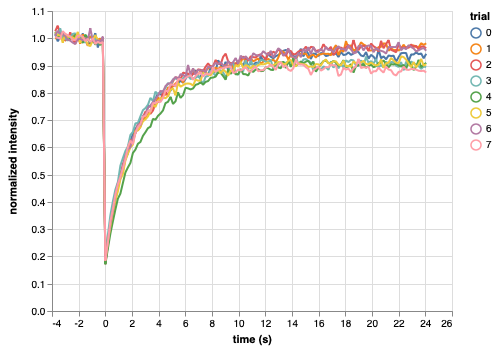

In [482]:
alt.Chart(df
    ).mark_line(
        strokeJoin='bevel'
    ).encode(
        x=alt.X('time:Q', title='time (s)'),
        y=alt.Y('normalized_intensity:Q', title='normalized intensity'),
        color='trial:N',
        order='time:Q'
    )

After looking at the data, let's generate a model:

In [564]:
# Model
def data_prior_pred(t, n_ppc_samples=1):
    '''
    Samples parameter values according to the prior and generates
    data y at the values given in x.
    '''
    sigma = np.abs(np.random.normal(0, 0.01, size=n_ppc_samples))
    i_0 = np.random.normal(1, sigma, size=n_ppc_samples)
    k_off = np.random.lognormal(np.log(0.2), 0.5, size=n_ppc_samples)
    D = np.random.lognormal(np.log(0.1), 0.75, size=n_ppc_samples)
    fb = np.random.beta(6, 3, size=n_ppc_samples)
    ff = np.random.beta(15, 2, size=n_ppc_samples)
    
    data = np.array([np.random.normal(fluo_bleach_cal(t0, fb, ff, k_off, D),
                                      sigma, size=1) 
                        for t0 in t])
    return np.concatenate(data)

Use trial0 to do prior check

In [565]:
t0 = df.loc[df['trial']==0, 'time'].values
v0 = df.loc[df['trial']==0, 'normalized_intensity'].values

In [567]:
# prior check use the data in trial0
colors = bokeh.palettes.all_palettes['Category20'][20]

p = bokeh.plotting.figure(height=300, width=450,
                          x_axis_label='time(s)',
                          y_axis_label='intensity')

# Plot simulated data
for i in range(20):
    p.line(t, data_prior_pred(t0), color=colors[i],
             alpha=0.8)

# Plot original data
p.circle(t0, v0, color='black', size=4)
bokeh.io.show(p)

Let's specify the likelihood and caculate the posterior

In [486]:
def log_prior(params):
    
    if (params < 0).any():
        return -np.inf
    
    fb, ff, k_off, D, sigma = params

    log_prior = st.beta.logpdf(fb, 6, 3)
    log_prior += st.beta.logpdf(ff, 15, 1)
    log_prior += st.lognorm.logpdf(k_off, 0.5, loc=0, scale=0.2)
    log_prior += st.lognorm.logpdf(D, 0.75, loc=0, scale=0.3)
    log_prior += st.halfnorm.logpdf(sigma, 0, 0.01)
    
    return log_prior

def log_like(params, t, y):
    fb, ff, k_off, D, sigma = params
    
    log_like = np.sum([st.norm.logpdf(y0, fluo_bleach_cal(t0, fb, ff, k_off, D), sigma)
                       for y0, t0 in zip(y, t)])
    
    return log_like

In [487]:
def log_post(params, t, y):
    return log_prior(params) + log_like(params, t, y)

def neg_log_post(params, t, y):
    return -log_post(params, t, y)

After several trial of find Map_values using different methods, we find that 'SLSQP' works the best for us.

In [488]:
# Specify arguments
args_0 = (t0, v0)

# Choose initial conditiona
params_0 = [0.9, 0.9, 0.2, 0.3, 0.01]

# Compute the MAP values
opt_res_0 = scipy.optimize.minimize(neg_log_post, params_0, args=args_0,
                                    method='SLSQP')

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [489]:
popt_0 = opt_res_0.x
print(popt_0)

[0.83928361 0.93895569 0.25985803 0.35063933 0.01314211]


In [490]:
# Do a posterior check with the real data

def data_prior_pred_0(t, n_ppc_samples=1):
    fb, ff, k_off, D, sigma = popt_0
    data = np.array([np.random.normal(fluo_bleach_cal(t0, fb, ff, k_off, D),
                                      sigma, size=1) 
                        for t0 in t0])
    return np.concatenate(data)


colors = bokeh.palettes.all_palettes['Category20'][20]

p = bokeh.plotting.figure(height=300, width=450,
                          x_axis_label='time(s)',
                          y_axis_label='intensity')

# Plot simulated data
for i in range(20):
    p.line(t, data_prior_pred_0(t0), color=colors[i],
             alpha=0.8)

# Plot original data
p.circle(t0, v0, color='black', size=4)
bokeh.io.show(p)

In [491]:
hes = smnd.approx_hess(popt_0, log_post, args=args_0)

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

# Look at it
for i in range(5):
    print(abs(cov[i][i]))
    

0.00016911904354358466
3.5268303496668336e-06
0.0004684908856278591
0.00944923475285257
5.669628436172438e-07


In [492]:
# For convenience...
fb_MAP_0, ff_MAP_0, k_off_MAP_0, D_MAP_0, sigma_MAP_0  = popt_0

# Print results
print("""
Most probable parameters for Trial0
-----------------------------------
fb_MAP_0 = {0:.2f} ± {1:.2f} 
ff_MAP_0 = {2:.3f} ± {3:.3f}
k_off_MAP_0 = {4:.3f} ± {5:.3f}
D_MAP_0 = {6:.3f} ± {7:.3f}
sigma_MAP_0 = {8:.3f} ± {9:.3f}
""".format(fb_MAP_0, 2* np.sqrt(abs(cov[0, 0])), 
           ff_MAP_0, 2* np.sqrt(abs(cov[1, 1])), 
           k_off_MAP_0, 2* np.sqrt(abs(cov[2, 2])),
           D_MAP_0, 2* np.sqrt(abs(cov[3, 3])),
           sigma_MAP_0, 2* np.sqrt(abs(cov[4, 4]))))


Most probable parameters for Trial0
-----------------------------------
fb_MAP_0 = 0.84 ± 0.03 
ff_MAP_0 = 0.939 ± 0.004
k_off_MAP_0 = 0.260 ± 0.043
D_MAP_0 = 0.351 ± 0.194
sigma_MAP_0 = 0.013 ± 0.002



To perform the similar method on all the trial, we would like to summarize the function into several blocks, and call the block for each trail to perform all the operation.

In [499]:
def slice_data_prior_check(i):
    ti = df.loc[df['trial']==i, 'time'].values
    vi = df.loc[df['trial']==i, 'normalized_intensity'].values
    
    colors = bokeh.palettes.all_palettes['Category20'][20]

    p = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='time(s)',
                              y_axis_label='intensity')

    # Plot simulated data
    for i in range(20):
        p.line(ti, data_prior_pred(ti), color=colors[i],
               alpha=0.8)

    # Plot original data
    p.circle(ti, vi, color='black', size=4)
    bokeh.io.show(p)
    return ti, vi

In [500]:
def compute_Map_values(i, ti, vi, params_i):
      # Specify arguments
        args_i = (ti, vi)
    
      # Choose initial condition
        params = params_i

     # Compute the MAP values
        opt_res_i = scipy.optimize.minimize(neg_log_post, params, args=args_i,
                                            method='SLSQP')

        #popt_i = opt_res_i.x
        
        #print(popt_i)
        print(opt_res_i.x)
        return opt_res_i.x

In [501]:
# Take a look at the best fit line¶ using the MAP Values we get back

def plot_best_fit_line(i, ti, vi, popt_i):
    def data_prior_pred_back(ti, n_ppc_samples=1):
        fb, ff, k_off, D, sigma = popt_i
        data = np.array([np.random.normal(fluo_bleach_cal(ti, fb, ff, k_off, D),
                                          sigma, size=1) 
                                           for ti in ti])
        return np.concatenate(data)

    colors = bokeh.palettes.all_palettes['Category20'][20]

    p = bokeh.plotting.figure(height=300, width=450,
                              x_axis_label='time(s)',
                              y_axis_label='intensity')

    # Plot simulated data
    for i in range(20):
        p.line(t, data_prior_pred_back(ti), color=colors[i],
               alpha=0.8)

    # Plot original data
    p.circle(ti, vi, color='black', size=4)
    bokeh.io.show(p) 
    

In [502]:
def present_parameter_with_95(i, popt_i, args_i):
    hes = smnd.approx_hess(popt_i, log_post, args=args_i,  epsilon=1e-8)
    
    # Compute the covariance matrix
    cov = -np.linalg.inv(hes)

    # Print results
    print("Trial", i)
    print("""
    Most probable parameters 
    ------------------------
    fb_MAP = {0:.2f} ± {1:.2f} 
    ff_MAP = {2:.3f} ± {3:.3f}
    k_off_MAP = {4:.3f} ± {5:.3f}
    D_MAP = {6:.3f} ± {7:.3f}
    sigma_MAP = {8:.3f} ± {9:.3f}
    
    --------------------------------------------
    """.format(popt_i[0], 2* np.sqrt(abs(cov[0, 0])), 
               popt_i[1], 2* np.sqrt(abs(cov[1, 1])), 
               popt_i[2], 2* np.sqrt(abs(cov[2, 2])),
               popt_i[3], 2* np.sqrt(abs(cov[3, 3])),
               popt_i[4], 2* np.sqrt(abs(cov[4, 4]))))

    #return fb, ff, k_off, D, sigma
    return [popt_i[0], 2* np.sqrt(abs(cov[0, 0]))], [popt_i[1], 2* np.sqrt(abs(cov[1, 1]))], [popt_i[2], 2* np.sqrt(abs(cov[2, 2]))], [popt_i[3], 2* np.sqrt(abs(cov[3, 3]))], [popt_i[4], 2* np.sqrt(abs(cov[4, 4]))] 

First let's test the function with Trial0 to make sure nothing everything is good.

In [503]:
for i in range(0,1):
    ti, vi = slice_data_prior_check(i)
    popt_i = compute_Map_values(i, ti, vi, [0.9, 0.9, 0.2, 0.3, 0.01])
    args_i = (ti, vi)
    plot_best_fit_line(i, ti, vi, popt_i)
    result_i = present_parameter_with_95(i, popt_i, args_i)
    fb = result_i[0][:]
    ff = result_i[1][:]
    k_off = result_i[2][:]
    D = result_i[3][:]
    sigma = result_i[4][:]

fb

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


[0.83928361 0.93895569 0.25985803 0.35063933 0.01314211]


Trial 0

    Most probable parameters 
    ------------------------
    fb_MAP = 0.84 ± 0.03 
    ff_MAP = 0.939 ± 0.004
    k_off_MAP = 0.260 ± 0.044
    D_MAP = 0.351 ± 0.198
    sigma_MAP = 0.013 ± 0.002
    
    --------------------------------------------
    


[0.8392836148380288, 0.02555706638944955]

The result is the same as what we get from direct operation on trial0, let's move on and use this on other trials.

In [504]:
for i in range(1,8):
    ti, vi = slice_data_prior_check(i)
    popt_i = compute_Map_values(i, ti, vi, [0.9, 0.9, 0.2, 0.3, 0.01])
    args_i = (ti, vi)
    plot_best_fit_line(i, ti, vi, popt_i)
    result_i = present_parameter_with_95(i, popt_i, args_i)
    fb = np.vstack([fb, result_i[0][:]])
    ff = np.vstack([ff, result_i[1][:]])
    k_off = np.vstack([k_off, result_i[2][:]])
    D = np.vstack([D, result_i[3][:]])
    sigma = np.vstack([sigma, result_i[4][:]])

/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


[0.86129599 0.96535866 0.13684461 0.80281412 0.01305148]


Trial 1

    Most probable parameters 
    ------------------------
    fb_MAP = 0.86 ± 0.02 
    ff_MAP = 0.965 ± 0.005
    k_off_MAP = 0.137 ± 0.020
    D_MAP = 0.803 ± 0.126
    sigma_MAP = 0.013 ± 0.001
    
    --------------------------------------------
    


/Users/chenxinhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]


[0.98474978 0.99999997 0.02838624 1.92344405 0.02470492]


Trial 2

    Most probable parameters 
    ------------------------
    fb_MAP = 0.98 ± 0.01 
    ff_MAP = 1.000 ± 0.013
    k_off_MAP = 0.028 ± 0.014
    D_MAP = 1.923 ± 0.148
    sigma_MAP = 0.025 ± 0.003
    
    --------------------------------------------
    


[0.78474126 0.90437715 0.36220628 0.22141881 0.01353727]


Trial 3

    Most probable parameters 
    ------------------------
    fb_MAP = 0.78 ± 0.02 
    ff_MAP = 0.904 ± 0.003
    k_off_MAP = 0.362 ± 0.026
    D_MAP = 0.221 ± 0.075
    sigma_MAP = 0.014 ± 0.002
    
    --------------------------------------------
    


[0.82388568 0.90590578 0.27202714 0.12969667 0.01077998]


Trial 4

    Most probable parameters 
    ------------------------
    fb_MAP = 0.82 ± 0.02 
    ff_MAP = 0.906 ± 0.003
    k_off_MAP = 0.272 ± 0.027
    D_MAP = 0.130 ± 0.087
    sigma_MAP = 0.011 ± 0.001
    
    --------------------------------------------
    


[0.81036589 0.90951356 0.30919394 0.18683416 0.01056887]


Trial 5

    Most probable parameters 
    ------------------------
    fb_MAP = 0.81 ± 0.02 
    ff_MAP = 0.910 ± 0.003
    k_off_MAP = 0.309 ± 0.020
    D_MAP = 0.187 ± 0.064
    sigma_MAP = 0.011 ± 0.001
    
    --------------------------------------------
    


[0.82717563 0.95898038 0.24048798 0.35336713 0.01223532]


Trial 6

    Most probable parameters 
    ------------------------
    fb_MAP = 0.83 ± 0.02 
    ff_MAP = 0.959 ± 0.003
    k_off_MAP = 0.240 ± 0.025
    D_MAP = 0.353 ± 0.109
    sigma_MAP = 0.012 ± 0.001
    
    --------------------------------------------
    


[0.80021727 0.890919   0.4098093  0.08007795 0.01148056]


Trial 7

    Most probable parameters 
    ------------------------
    fb_MAP = 0.80 ± 0.02 
    ff_MAP = 0.891 ± 0.003
    k_off_MAP = 0.410 ± 0.027
    D_MAP = 0.080 ± 0.060
    sigma_MAP = 0.011 ± 0.001
    
    --------------------------------------------
    


After running through each trial, we would have a numpy array for each parameter, let's look at all the paramter.

In [558]:
print("fb[value, 95%interval]:", '\n', fb)

fb[value, 95%interval]: 
 [[0.83928361 0.02555707]
 [0.86129599 0.02055443]
 [0.98474978 0.01350626]
 [0.78474126 0.01918692]
 [0.82388568 0.02132988]
 [0.81036589 0.01578645]
 [0.82717563 0.01741692]
 [0.80021727 0.01933533]]


In [557]:
print("ff[value, 95%interval]:", '\n', ff)

ff[value, 95%interval]: 
 [[0.93895569 0.00370667]
 [0.96535866 0.00502643]
 [0.99999997 0.01307108]
 [0.90437715 0.00309907]
 [0.90590578 0.00297834]
 [0.90951356 0.00259065]
 [0.95898038 0.00337409]
 [0.890919   0.00255842]]


In [559]:
print("k_off[value, 95%interval]:", '\n', k_off)

k_off[value, 95%interval]: 
 [[0.25985803 0.04420454]
 [0.13684461 0.02012008]
 [0.02838624 0.01398956]
 [0.36220628 0.02573287]
 [0.27202714 0.02675685]
 [0.30919394 0.01961199]
 [0.24048798 0.02492068]
 [0.4098093  0.02661427]]


In [560]:
print("D[value, 95%interval]:", '\n', D)

D[value, 95%interval]: 
 [[0.35063933 0.19797931]
 [0.80281412 0.12640201]
 [1.92344405 0.14786993]
 [0.22141881 0.07484298]
 [0.12969667 0.08731727]
 [0.18683416 0.06430942]
 [0.35336713 0.10906808]
 [0.08007795 0.06043442]]


In [561]:
print("sigma[value, 95%interval]:", '\n', sigma)

sigma[value, 95%interval]: 
 [[0.01314211 0.00150642]
 [0.01305148 0.00149649]
 [0.02470492 0.0029781 ]
 [0.01353727 0.00154924]
 [0.01077998 0.00123941]
 [0.01056887 0.00121549]
 [0.01223532 0.00140403]
 [0.01148056 0.00132163]]
